## Using Plume Vetting demo

- Original paper: *Xiang, Chuchu, et al. "Identification of false methane plumes for orbital imaging spectrometers: A case study with EMIT." RSE 328 (2025)*
- Original codebase: https://github.com/emit-sds/plume-vetting
- This demo notebook author: Vit Ruzicka


In [ ]:
# Get the repo

!git clone https://github.com/previtus/using_plume_vetting.git

# Install relevant libraries:

!pip install earthaccess
!pip install georeader-spaceml
!pip install netCDF4

In [1]:
%cd /content/using_plume_vetting

/content/using_plume_vetting


In [2]:
import os.path, sys
import numpy as np
import pylab as plt
from utils import rio_load
from utils import vec_load, shapely_multipolygon_to_polygons, geopandas_to_shapely
from utils import how_many_pixels_does_polygon_occupy
from utils import download_granule, get_cmf_name, get_rad_name, get_mask_name, get_obs_name
from utils import NCImage

from plume_vetting.sfun import get_radiance_ratio, calculate_fit, calculate_dist, calculate_magnitude
from plume_vetting_utils import compute_masks, coords_inside_plume_from_binary
from main_plume_scoring_demo import load_and_prep_data, run_plume_vetting_on_scene

Note that here we use saved predictions from machine learning models for detection of methane leaks (represented as the .gpkg files), replace this with outputs of your own models.

authenticated with earthaccess: True
Already dowloaded previously, skipping!
Loaded data for [EMIT_L1B_RAD_001_20240625T065045_2417705_028]: L1B: (2032, 2097, 285) CMF: (2032, 2097) cloud mask: (2032, 2097) and 6 polygons!
rdn: (2032, 2097, 285)
cmf: (2032, 2097)
mask: (2032, 2097)
vectors: [<POLYGON ((51.607 29.995, 51.611 29.994, 51.611 29.996, 51.613 29.996, 51.61...>, <POLYGON ((51.611 29.965, 51.611 29.966, 51.609 29.966, 51.61 29.968, 51.614...>, <POLYGON ((51.613 29.971, 51.613 29.972, 51.614 29.971, 51.612 29.971, 51.61...>, <POLYGON ((51.59 30.003, 51.587 30.004, 51.587 30.005, 51.589 30.005, 51.591...>, <POLYGON ((51.587 30.012, 51.588 30.012, 51.588 30.011, 51.587 30.01, 51.589...>, <POLYGON ((51.615 30.095, 51.617 30.092, 51.624 30.092, 51.625 30.089, 51.62...>]
cmf_path: /content/using_plume_vetting/data/EMIT_L1B_RAD_001_20240625T065045_2417705_028/EMIT_L2B_CH4ENH_002_20240625T065045_2417705_028.tif
scene_target_signature: (285,)
Polygon #0 (7210px)


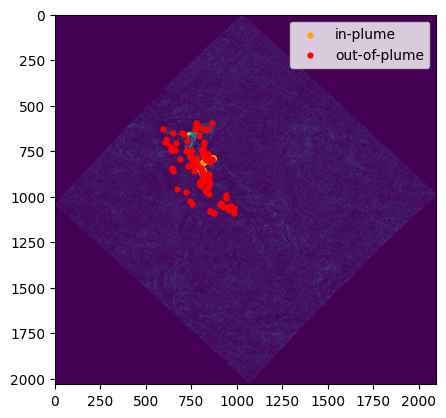

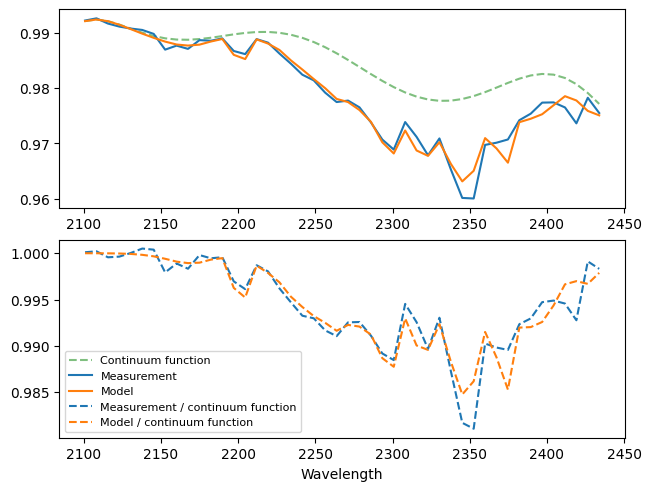

D_norm =  0.268
Estimated_concentration_len =  1346.215
Polygon #1 (27px)


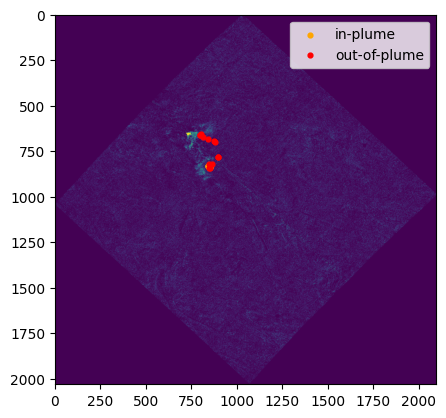

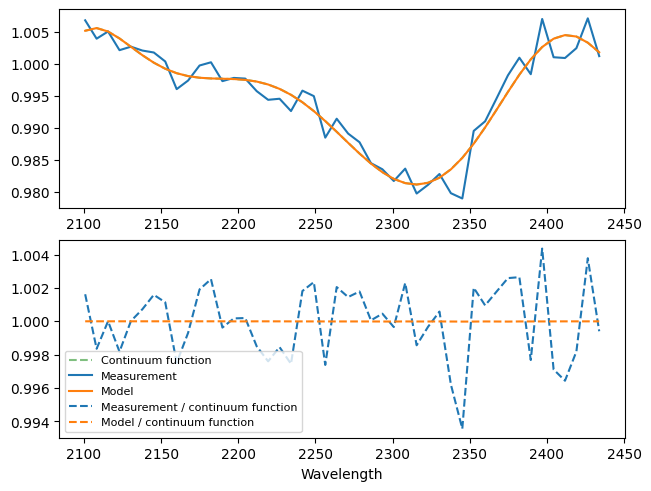

D_norm =  1.0
Estimated_concentration_len =  1.525
Polygon #4 (363px)


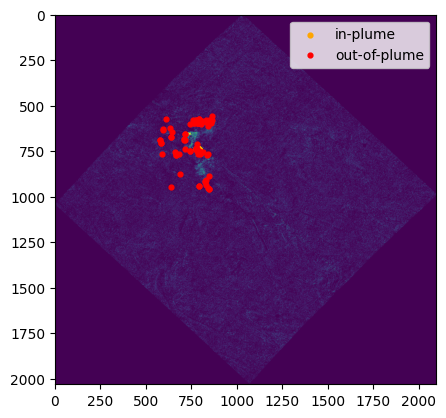

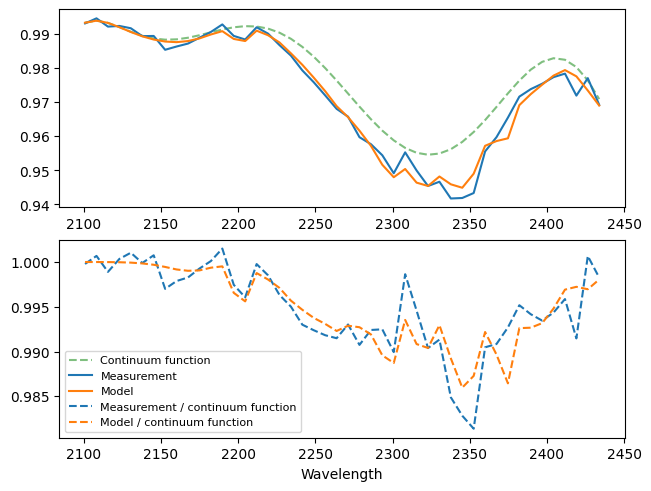

D_norm =  0.433
Estimated_concentration_len =  1239.391
Polygon #5 (9468px)


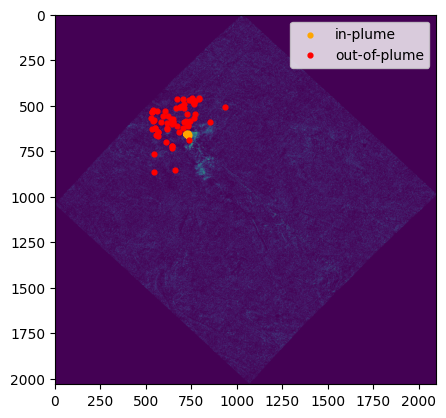

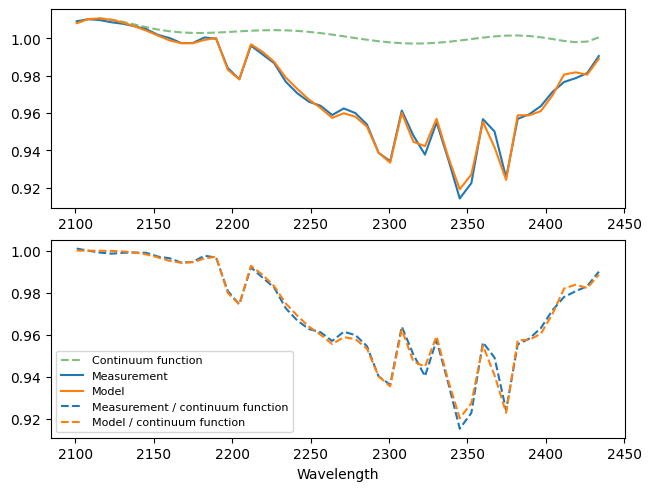

D_norm =  0.082
Estimated_concentration_len =  7291.807
Output: {0: {'D_norm': np.float64(0.26776983096333695), 'alpha_con_len': np.float64(1346.2153866958133)}, 1: {'D_norm': np.float64(1.0001837310356083), 'alpha_con_len': np.float64(1.5245469530050957)}, 4: {'D_norm': np.float64(0.4327462590183983), 'alpha_con_len': np.float64(1239.390722036469)}, 5: {'D_norm': np.float64(0.08177880669368734), 'alpha_con_len': np.float64(7291.807304513205)}}


In [3]:
num_pts = 40
debug_jump_to = None

# tile_id = "EMIT_L1B_RAD_001_20240215T193425_2404613_030"
tile_id = "EMIT_L1B_RAD_001_20240625T065045_2417705_028"
raws_download_folder = "/content/using_plume_vetting/data/"+tile_id
predictions_path = "/content/using_plume_vetting/data/"+tile_id+"/ensemble_predictions.gpkg"

# This will download the source L1 data
rdn, cmf, mask, vectors, cmf_path, scene_target_signature = load_and_prep_data(tile_id,predictions_path,raws_download_folder)

# TODO: Feel free to completely replace the data loading part with your own functions ... this should work on LP DAAC formats
# TODO: Following shapes are kept for easier reproduction...
print("rdn:", rdn.shape) # (2032, 2097, 285)
print("cmf:", cmf.shape) # (2032, 2097)
print("mask:", mask.shape) # (2032, 2097)
print("vectors:", vectors) # list of shapely polygons ... [<POLYGON (...>, <POLYGON (....>]
print("cmf_path:", cmf_path) # .../EMIT_L2B_CH4ENH_002_20240625T065045_2417705_028.tif
print("scene_target_signature:", scene_target_signature.shape)

scores_per_polygon = run_plume_vetting_on_scene(rdn, cmf, mask, vectors, cmf_path, scene_target_signature, debug_viz=True,
                            num_pts = num_pts, debug_jump_to=debug_jump_to, min_polygon_size = 20)

print("Output:", scores_per_polygon)

In [9]:
print("For", len(vectors), "vectors, we have", len(scores_per_polygon.keys()),"scores (remember, we filtered by min_polygon_size = 20 - set this to 0 to score all)")
for k in scores_per_polygon.keys():
  print("Plume", k, ":", "D_norm =", scores_per_polygon[k]["D_norm"], "Estim. conc. lenght =", scores_per_polygon[k]["alpha_con_len"])


For 6 vectors, we have 4 scores (remember, we filtered by min_polygon_size = 20 - set this to 0 to score all)
Plume 0 : D_norm = 0.26776983096333695 Estim. conc. lenght = 1346.2153866958133
Plume 1 : D_norm = 1.0001837310356083 Estim. conc. lenght = 1.5245469530050957
Plume 4 : D_norm = 0.4327462590183983 Estim. conc. lenght = 1239.390722036469
Plume 5 : D_norm = 0.08177880669368734 Estim. conc. lenght = 7291.807304513205


**How to read these scores?**

Low D_norm and high estimated concentration lenght can guide us towards true plume detections (and the opposite to potential false alerts). Read the paper for more details ...